In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
import shutil
import os
import pathlib

2024-11-09 16:15:31.269326: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 16:15:31.302172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 16:15:31.307030: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 16:15:31.319267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 16:15:31.338623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

In [3]:
# Data Pull
# Specify the URL for the dataset
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/vmox93cwsx2vzrish3l63/land_ls_model_data_four.zip?rlkey=6uykz7bb0aoqbl8hgfkpt1t4f&dl=0?raw=1"
data_dir = tf.keras.utils.get_file('land_ls_model_data_four.zip', origin=dataset_url, extract=True)

# Convert to pathlib object for easier handling
data_dir = pathlib.Path(data_dir).with_suffix('')

# Check how many images are in the dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total number of images in the dataset: {image_count}')

Total number of images in the dataset: 3200


In [4]:
# Paths to dataset
extracted_dir = '/home/mjp2da/.keras/datasets/land_ls_model_data_four'  # Adjusted path

# Create directories for training and validation
train_dir = os.path.join(extracted_dir, 'train')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

In [5]:
# Move 'landslide' and 'non_landslide' directories into the 'train' folder
landslide_dir = os.path.join(extracted_dir, 'landslide')
non_landslide_dir = os.path.join(extracted_dir, 'non_landslide')
shutil.move(landslide_dir, os.path.join(train_dir, 'landslide'))
shutil.move(non_landslide_dir, os.path.join(train_dir, 'non_landslide'))

Error: Destination path '/home/mjp2da/.keras/datasets/land_ls_model_data_four/train/landslide/landslide' already exists

In [6]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide
train
test


In [26]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [27]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

Found 2921 images belonging to 2 classes.


In [28]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 730 images belonging to 2 classes.


In [29]:
# Load MobileNet as the base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

In [30]:
# Final model
model = Model(inputs=base_model.input, outputs=output)

In [31]:
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
# Train the model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10


/home/mjp2da/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.8510 - loss: 0.3506 - val_accuracy: 0.9048 - val_loss: 0.2409
Epoch 2/10
 1/91 ━━━━━━━━━━━━━━━━━━━━ 1:05 723ms/step - accuracy: 0.8438 - loss: 0.3203

2024-11-09 16:49:07.918573: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8438 - loss: 0.3203 - val_accuracy: 0.7692 - val_loss: 0.4064
Epoch 3/10


2024-11-09 16:49:08.603007: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9448 - loss: 0.1425 - val_accuracy: 0.9446 - val_loss: 0.1416
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0265 - val_accuracy: 0.9615 - val_loss: 0.1486
Epoch 5/10


2024-11-09 16:51:17.124206: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9478 - loss: 0.1221 - val_accuracy: 0.9531 - val_loss: 0.1191
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.9231 - val_loss: 0.2198
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9592 - loss: 0.0981 - val_accuracy: 0.9645 - val_loss: 0.1015
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9688 - loss: 0.1080 - val_accuracy: 1.0000 - val_loss: 0.0331
Epoch 9/10


2024-11-09 16:55:31.840304: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


91/91 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.9710 - loss: 0.0831 - val_accuracy: 0.9616 - val_loss: 0.0968
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9688 - loss: 0.1509 - val_accuracy: 1.0000 - val_loss: 0.0441


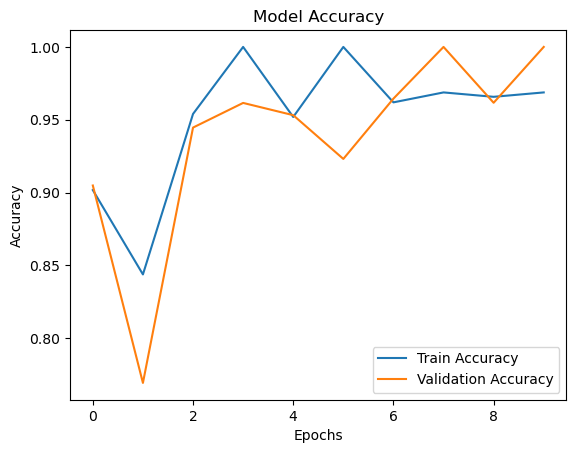

In [33]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [34]:
landslide_img_one_url = "https://dl.dropboxusercontent.com/scl/fi/viovy9pcma2y6hq58ntns/NASA_GoogE_14445.jpg?rlkey=ltitymrzuarrxxogge32c1kbi&dl=0?raw=1"
landslide_img_two_url = "https://dl.dropboxusercontent.com/scl/fi/7x41si7aih0bjh1py2phy/NASA_GoogE_14445_NonSlide.jpg?rlkey=3ll97pdrjwr9b10rcvineeynm&dl=0?raw=1"

In [35]:
# Download images
landslide_img_one_path = tf.keras.utils.get_file('NASA_GoogE_14445', origin=landslide_img_one_url)
landslide_img_two_path = tf.keras.utils.get_file('NASA_GoogE_14445_NonSlide', origin=landslide_img_two_url)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


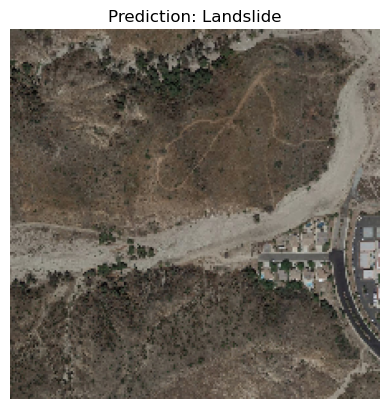

In [36]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Function to display predictions
def display_predictions(image_path, model):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    prediction = model.predict(img_array)

    plt.imshow(img)
    plt.title(f"Prediction: {'Landslide' if prediction[0] > 0.5 else 'Non-Landslide'}")
    plt.axis('off')
    plt.show()

# Example prediction for a test image
test_image_path = landslide_img_one_path 
display_predictions(test_image_path, model)


In [37]:
# Evaluate on test set and plot results
test_loss, test_acc = model.evaluate(validation_generator)
print(f'Test Accuracy: {test_acc:.4f}')


23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 994ms/step - accuracy: 0.9640 - loss: 0.1067
Test Accuracy: 0.9589


Seperate Test Dataset

In [38]:
# Specify the path to the zip file
# https://www.dropbox.com/scl/fi/wbi8iuftwvwnflvjr15pv/test_googleimages_land.zip?rlkey=h2stfvt9ocltsog29l26wo1ls&dl=0
# https://www.dropbox.com/scl/fi/w6fa6pd6hq7815p0jgkm2/test_google_images_landslides_two.zip?rlkey=zxiexqgti6b2nyemywc3itmhm&dl=0
test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/w6fa6pd6hq7815p0jgkm2/test_google_images_landslides_two.zip?rlkey=zxiexqgti6b2nyemywc3itmhm&dl=0?raw=1"

In [39]:
data_dir_test = tf.keras.utils.get_file('test_google_images_landslides_two.zip', origin=test_dataset_url, extract=True)
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [40]:
for root, dirs, files in os.walk(data_dir_test):
    print(root, dirs, files)

/home/mjp2da/.keras/datasets/test_google_images_landslides_two ['Google_Earth_Images'] []
/home/mjp2da/.keras/datasets/test_google_images_landslides_two/Google_Earth_Images ['landslides', 'non-landslides'] ['.DS_Store']
/home/mjp2da/.keras/datasets/test_google_images_landslides_two/Google_Earth_Images/landslides [] ['nasa_g_4500m_11542_2018_cat_town.jpg', 'nasa_g_2014m_11257_2020_large.jpg', 'nasa_g_4100m_4802_2013_vylg_two.jpg', 'NASA_GoogE_11454_large.jpg', 'nasa_g_4263m_12654_2023_cat.jpg', 'NASA_Arc_14329_large.jpg', 'nasa_g_3015m_12654_2023_cat.jpg', 'nasa_g_2715m_12699_2019_large_v3.jpg', 'nasa_g_2335m_9691_2017_large.jpg', 'nasa_g_4161m_11542_2021_cat.jpg', 'nasa_g_1950m_14143_2018_vylg.jpg', 'nasa_g_2715m_12699_2019_large_v1.jpg', 'NASA_GoogE_10521_large.jpg', 'nasa_g_2715m_12699_2019_large_v2.jpg', 'nasa_g_4161m_11542_2018_cat.jpg', 'nasa_g_4150m_5501_2013_vylg.jpg', 'NASA_GoogE_14445_cat.jpg', 'nasa_g_4550m_11363_2020_large.jpg', 'nasa_g_2000m_10521_2017_large_two.jpg', 'nasa

In [42]:
extracted_path = pathlib.Path(data_dir_test).with_suffix('')  # Remove the .zip suffix
print("Extracted directory:", extracted_path)

# Check if the directory exists
if os.path.exists(extracted_path):
    print("Directory exists!")
else:
    print("Directory does not exist!")

Extracted directory: /home/mjp2da/.keras/datasets/test_google_images_landslides_two
Directory exists!


In [43]:
# Specify the path to the downloaded zip file
zip_file_path = '/home/mjp2da/.keras/datasets/test_google_images_landslides_two.zip'

# Check if the file exists
if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Extraction completed successfully.")
else:
    print("The zip file doesn't exist.")

Extraction completed successfully.


In [44]:
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images


In [45]:
data_dir_test_lvltwo=pathlib.Path(data_dir_test) / 'Google_Earth_Images'
data_dir_test_lvltwo

PosixPath('/home/mjp2da/.keras/datasets/test_google_images_landslides_two/Google_Earth_Images')

In [46]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test_lvltwo,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=512,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 93 files belonging to 2 classes.


In [47]:
print("Evaluate on test landslide images")
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 720ms/step - accuracy: 0.3416 - loss: 3.9072
test loss, test acc: [2.8078272342681885, 0.5268816947937012]
